In [1]:
import os
import sys
import requests
from dotenv import load_dotenv
from typing import Dict, Any

# Add current directory to path for imports
sys.path.insert(0, os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd())

print(sys.path)
print(os.getcwd())

load_dotenv("/Users/paddy/Documents/Github/Dump-Truck/langgraph-sql-agent/.env")

['/Users/paddy/Documents/Github/Dump-Truck/langgraph-sql-agent', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python312.zip', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/lib-dynload', '', '/Users/paddy/Documents/Github/Dump-Truck/.venv/lib/python3.12/site-packages']
/Users/paddy/Documents/Github/Dump-Truck/langgraph-sql-agent


True

In [2]:
import os
from opentelemetry import trace as trace_api
from opentelemetry.sdk.trace.export import BatchSpanProcessor

from phoenix.otel import HTTPSpanExporter
from arize.otel import register as arize_register, Transport
from openinference.instrumentation.langchain import LangChainInstrumentor

PHOENIX_COLLECTOR = "https://app.phoenix.arize.com/s/padmanabhan-rajendra/v1/traces"
PHOENIX_API_KEY = os.environ.get("PHOENIX_API_KEY")

# Enable debug logging to troubleshoot
os.environ["OTEL_LOG_LEVEL"] = "debug"

# 1) Arize tracer provider with explicit endpoint and transport
tracer_provider = arize_register(
    space_id=os.environ["ARIZE_SPACE_ID"],
    api_key=os.environ["ARIZE_API_KEY"],
    project_name="sql-agent"
)

# 2) Add Phoenix exporter as an additional span processor
phoenix_exporter = HTTPSpanExporter(
    endpoint=PHOENIX_COLLECTOR,
    headers={"authorization": f"Bearer {PHOENIX_API_KEY}"},
)
phoenix_processor = BatchSpanProcessor(phoenix_exporter)

# Add the Phoenix processor to the existing tracer provider
tracer_provider.add_span_processor(phoenix_processor)

# 3) Add local Phoenix target (optional)
local_exporter = HTTPSpanExporter(endpoint="http://127.0.0.1:6006/v1/traces")
local_processor = BatchSpanProcessor(local_exporter)
tracer_provider.add_span_processor(local_processor)

# 4) Set global + instrument LangChain
trace_api.set_tracer_provider(tracer_provider)
LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

print("LangChain instrumented → Arize AX + Phoenix Cloud + Local Phoenix")

# NOTE: At the end of your application, add this to ensure spans are exported:
# tracer_provider.force_flush(timeout_millis=30000)

Overriding of current TracerProvider is not allowed


🔭 OpenTelemetry Tracing Details 🔭
|  Arize Project: sql-agent
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.arize.com
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'api_key': '****', 'arize-space-id': '****', 'space_id': '****', 'arize-interface': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

LangChain instrumented → Arize AX + Phoenix Cloud + Local Phoenix


In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# from langchain.chat_models import init_chat_model
# model = init_chat_model("gpt-3.5-turbo")

# from langchain_google_genai import ChatGoogleGenerativeAI
# model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

from langchain_anthropic import ChatAnthropic
model = ChatAnthropic(model="MiniMax-M2.1", temperature=0, base_url=os.environ["ANTHROPIC_BASE_URL"])

# from langchain_deepseek import ChatDeepSeek
# model = ChatDeepSeek(
#     model="deepseek/deepseek-v3.2",
#     api_key=os.getenv("OPENROUTER_API_KEY"),
#     api_base="https://openrouter.ai/api/v1",
#     extra_body={"reasoning": {"enabled": True}},
# )

In [4]:
from langchain_community.utilities import SQLDatabase

# Get PostgreSQL credentials from environment
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create PostgreSQL connection
db_uri = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
db = SQLDatabase.from_uri(db_uri)

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM future_jobs LIMIT 5;")}')

Dialect: postgresql
Available tables: ['future_jobs']
Sample output: [(1, 'Quantum Researcher', 'Quantum Computing', 'Singapore', 175780, 'Linear Algebra, Quantum Algorithms', 'No', 'Large', datetime.date(2025, 7, 22), 'Quantum Researcher Quantum Computing Linear Algebra, Quantum Algorithms Singapore'), (2, 'Renewable Energy Engineer', 'Green Tech', 'Singapore', 137481, 'Climate Data Analysis, Energy Modeling', 'Yes', 'Large', datetime.date(2025, 9, 26), 'Renewable Energy Engineer Green Tech Climate Data Analysis, Energy Modeling Singapore'), (3, 'Quantum Researcher', 'Quantum Computing', 'Tokyo', 182081, 'Linear Algebra, Qiskit', 'No', 'Medium', datetime.date(2025, 12, 31), 'Quantum Researcher Quantum Computing Linear Algebra, Qiskit Tokyo'), (4, 'Sustainability Analyst', 'Green Tech', 'Singapore', 113822, 'Climate Data Analysis, Energy Modeling', 'No', 'Large', datetime.date(2025, 5, 29), 'Sustainability Analyst Green Tech Climate Data Analysis, Energy Modeling Singapore'), (5, 'Smar

In [5]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [6]:
from typing import Literal

from langchain.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = model.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

IMPORTANT: In PostgreSQL, when using aggregate functions like MAX(), MIN(), COUNT(), etc.,
ALL non-aggregated columns in the SELECT clause MUST appear in the GROUP BY clause.
If you don't need grouping, use ORDER BY with LIMIT instead.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = model.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = model.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [7]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

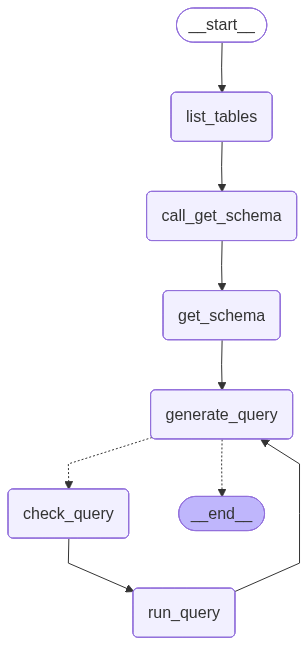

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
question = "Which job is the highest paid in 2025 in USA?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which job is the highest paid in 2025 in USA?
================================== Ai Message ==================================

Available tables: future_jobs
================================== Ai Message ==================================

[{'signature': '443930f633c7e50519239594bfa75ce20720b4dafcc7ebc3fb0c0aad23b30989', 'thinking': 'The user is asking about the highest paid job in 2025 in USA. I can see there\'s a table called "future_jobs" which likely contains information about jobs and their salaries. Let me first check the schema of this table to understand what columns it has.', 'type': 'thinking'}, {'id': 'call_function_0nltx3mzbh1h_1', 'input': {'table_names': 'future_jobs'}, 'name': 'sql_db_schema', 'type': 'tool_use'}]
Tool Calls:
  sql_db_schema (call_function_0nltx3mzbh1h_1)
 Call ID: call_function_0nltx3mzbh1h_1
  Args:
    table_names: future_jobs
================================= Tool Messa